## Point Localization -- Condensed

In [1]:
import os
import scipy.signal as sp
%matplotlib inline
import sys  
import importlib

sys.path.append('../Libraries') # adjust as needed

# load the local library
import sdc_config3 as sdc
import gaussplat as gp
import gauss_splat_2 as gp2

# array compute and plotting
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio

# for gaussian functions and plotting
from mpl_toolkits.mplot3d import Axes3D
from torch.distributions.multivariate_normal import MultivariateNormal


### Forward model parameters
Filter mask, PSF

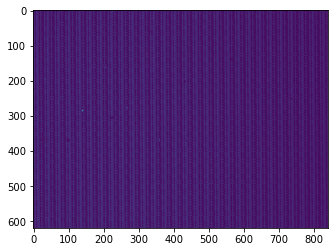

Shape of the filter array: torch.Size([620, 840, 45])


In [3]:
# Filter mask

# Load filter calibration data
data_folder = '../Calibration_Data'
file_name = 'filterCal_every2nm_darksub_2021-02-03.mat'

# Import the filter stack from the specified file
wavelengths, ci, filter_stack = sdc.importFilterStack(data_folder, file_name)

# Adjust CI values for zero-based indexing
# Define the cropped part of the image
ci_adjusted = [ci[0] - 1, ci[1] - 1, ci[2], ci[3]]

# Define wavelength sampling parameters
wavelength_min = 450
wavelength_max = 800
wavelength_step = 8

# Create a new array of wavelengths
wavelength_new = np.arange(wavelength_min, wavelength_max + wavelength_step, wavelength_step)

# Sum the filter array over the specified wavelength range
filt_arr = sdc.sumFilterArray(filter_stack, wavelengths, wavelength_min, wavelength_max, wavelength_step)
filt_arr = filt_arr / np.amax(filt_arr) # normalize
m = torch.tensor(filt_arr) # make tensor

# Plot the sum of the filter array across the last dimension
plt.figure()
plt.imshow(torch.sum(m, axis=2))
plt.show()

# Print the shape of the tensor
print("Shape of the filter array:", m.shape)

# Extract dimensions for further processing
# NL is the number of wavelengths
NY, NX, NL = m.shape

torch.Size([620, 840])


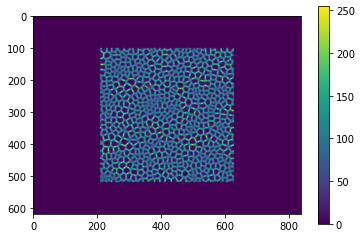

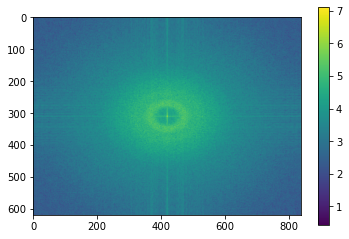

In [4]:
# PSF

datafolder = '../Calibration_Data'
fname = 'psf_090_1.png'
psf = torch.from_numpy(imageio.imread(os.path.join(datafolder, fname)))

 # Expand the PSF to match the shape of the filter array
pad_h = (m.shape[0] - psf.shape[0]) // 2
pad_w = (m.shape[1] - psf.shape[1]) // 2
padding = (pad_w, m.shape[1] - psf.shape[1] - pad_w, pad_h, m.shape[0] - psf.shape[0] - pad_h)
h = torch.nn.functional.pad(psf, padding, mode='constant', value=0)
print(h.shape)

plt.figure()
plt.imshow(h)
plt.colorbar()
plt.show()

hf = torch.fft.fftshift(torch.fft.fft2(h,dim=(0,1)))
plt.imshow(torch.log10(torch.abs(hf)))
plt.colorbar()
plt.show()

### Construct ground truth gaussian object

In [5]:
# Ground truth parameters -- must be floats
muy = 0.0
mux = 100.0
mul = 0.0
sigy = 10.0
sigx = 10.0
sigl = 1.0
NY, NX, NL = m.shape

In [7]:
# Create gaussian object and 3D array
g_ground = gp.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[x,y,coords] = gp.createMeshGrid(NX, NY)
g3d = g_ground.createPixelGauss(NY,NX,NL)
g3d_proj = g3d.sum(dim=2).detach()

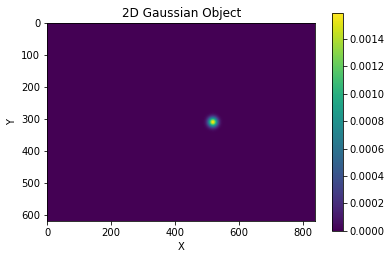

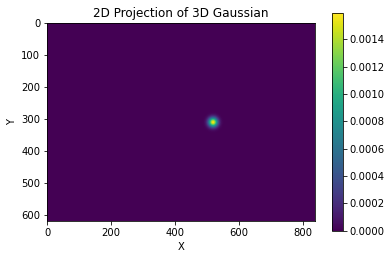

In [8]:
g_ground.plot(coords,NY,NX)
g_ground.plot3D(NY,NX,NL)

### Get ground truth measurement

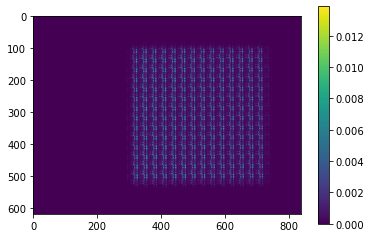

In [9]:
# Pad PSF
h_padded = sdc.pad(h) # double the size of h
h_padded_3d = sdc.make3d(h_padded, NL) # copy h NL times along the 3rd dimension
hf_padded_3d = sdc.fft3d(h_padded_3d) # take fft along dim 0 and 1

# Pad X
g3d_padded = sdc.pad(g3d)

# Get measurement
measurement = sdc.forwardmodel3d(g3d_padded, hf_padded_3d, m)
measurement = measurement/torch.norm(measurement) # normalize
plt.figure()
plt.imshow(measurement.detach().numpy())
plt.colorbar()
plt.show() 

### Initialize random gaussian guess

### Gradient descent